## Logistical Regression

### What are the odds that something will happen? Answering Yes/No questions

####  - will I get the loan I want at a favorable interest rate?
    i.e. Can I get a loan, form the Lending Club, of $10000 at 12% or less, with a FICO Score of 720?
    or : What is the probability of getting a Loan of $10000 at 12% or less with a FICO Score of 720?

Setting a probability of 0.67 for the threshold which tells us we WILL get the loan. Setting it at 0.8 would mean we were "more certain" that it will happen

In [16]:
# Using the cleaned up Lending Club data for input.

% pylab inline
import pandas as pd
dfr = pd.read_csv('/home/sophie/projects/LendingClub/data/clean_LD.csv')

# The tutorial has Interest.Rate in %, me in decimals. Fix

dfr['Interest.Rate'] = dfr["Interest.Rate"]*100

dfr.head()

Populating the interactive namespace from numpy and matplotlib


,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length,FICO.Score
0,20000,20000.0,8.90,36,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,14.0,14272.0,2.0,< 1 year,735
1,19200,19200.0,12.12,36,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,12.0,11140.0,1.0,2 years,715
2,10000,9975.0,9.99,36,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,10.0,9346.0,0.0,5 years,695
3,12000,12000.0,11.71,36,credit_card,18.78%,NJ,RENT,3195.00,11.0,14469.0,0.0,9 years,695
4,6000,6000.0,15.31,36,other,20.05%,CT,OWN,4891.67,17.0,10391.0,2.0,3 years,670


In [17]:
# Add a column to indicate (True/False) whether the interest rate is <= 12

dfr['TF'] = dfr['Interest.Rate'] <= 12  # checked and works.

In [18]:
# now we check the rows that have interest rate == 10 (a random choice for some number < 12)
# This is a check to confirm that TF value is True where it should be

d = dfr[dfr['Interest.Rate']==10] # yes, this checks out

Now we create a Logit model using the data and model software. 'TF' column is the dependent (response) variable and 'FICO.Score' and 'Loan.Amount' are independent (predictor) variables.

In [19]:
import statsmodels.api as sm
# statsmodels requires us to add a constant column representing the intercept
dfr['intercept'] = 1.0

# identify the independent variables
ind_cols=['FICO.Score','Amount.Requested','intercept']
# sm.Logit(endog,exog, **kwargs). endog = 1D response var, exog = nobs x k array(included intercept added by user)
logit = sm.Logit(dfr['TF'],dfr[ind_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.307638
         Iterations 8


So, what are the results? What are the fitted coefficients computed by the software?

In [21]:
# get the fitted coefficients from the results
coeff = result.params
print coeff

FICO.Score           0.096533
Amount.Requested    -0.000191
intercept          -66.352340
dtype: float64


From the results, the linear part of our predictor is:   
    $z = -60.125 + 0.096533 * FicoScore - 0.000191 * AmountRequested $    
This is multivariate linear regression.     
Finally, the probability of our desired outcome, i.e. getting a loan at 12% interest or less, is:

$p(z) = {1\over1 + e^{(b_0+b_1*FicoScore+b_2*LoanAmount)}}$  

where $b_0 = -60.125$, $b_1 = 0.087423$ and $b_2 = -0.000174$   


We need to create a function in code to encapsulate all this.
It will take the following input:
    - A borrowers FICO score
    - The desired loan amount
    - The coefficient vector
It will return the probability of getting a loan, between 0-1

In [22]:
def pz(fico, amt, coeff):
    # compute the linear expression by multiplying the inputs by their respective coefficients.
    # note that the coefficient array has the intercept coefficient at the nd
    z = coeff[0]* fico + coeff[1]*amt + coeff[2]
    return 1/(1+exp(-1*z))


Now we use our data FICO = 720 and Loan Amount=10000 to get a probability using the z value and the logistic formula

In [23]:
pz(720,10000,coeff)

0.77597903100189791

This value of 0.7759 tells us we have a good chance of getting the loan we want (considering anything over 0.67 was a yes).
Now we will experiement with various sets of input data for FICO score and Loan Amount requested

In [24]:
print("Trying multiple FICO Loan Amount combinations: ")
print('----')
print("fico=720, amt=10,000")
print(pz(720,10000,coeff))
print("fico=720, amt=20,000")
print(pz(720,20000,coeff))
print("fico=720, amt=30,000")
print(pz(720,30000,coeff))
print("fico=820, amt=10,000")
print(pz(820,10000,coeff))
print("fico=820, amt=20,000")
print(pz(820,20000,coeff))
print("fico=820, amt=30,000")
print(pz(820,30000,coeff))

Trying multiple FICO Loan Amount combinations: 
----
fico=720, amt=10,000
0.775979031002
fico=720, amt=20,000
0.339239916338
fico=720, amt=30,000
0.0707153575586
fico=820, amt=10,000
0.999981462395
fico=820, amt=20,000
0.999874943716
fico=820, amt=30,000
0.999156875551


With a lower FICO Score of 720 the person will have a lower probability of getting the loan. With a Higher FICO score,
you are more likely to be accepted for loans up to $30 000

In [30]:
print "FICO 820,Amount $50000 = %f probability "% (pz(829,50000,coeff))

FICO 820,Amount $50000 = 0.984144 probability 


In [31]:
print "FICO 820,Amount $60000 = %f probability "% (pz(829,60000,coeff))

FICO 820,Amount $60000 = 0.901955 probability 


In [32]:
print "FICO 820,Amount $70000 = %f probability "% (pz(829,70000,coeff))

FICO 820,Amount $70000 = 0.576903 probability 


In [33]:
print "FICO 820,Amount $630000 = %f probability "% (pz(829,63000,coeff))

FICO 820,Amount $630000 = 0.838407 probability 


In [34]:
print "FICO 820,Amount $65000 = %f probability "% (pz(829,65000,coeff))

FICO 820,Amount $65000 = 0.779818 probability 


The results above suggest that the liklihood of being accepted for a loan, with a FICO score of 820, falls sharply between \$60000 and \$70000. Anything over \$65000 could be risky. 

### Challenge Exercise

Create a yes/no plot for loan amount on x-axis and probability of loan on y-axis for a FICO score of 820 and 720.

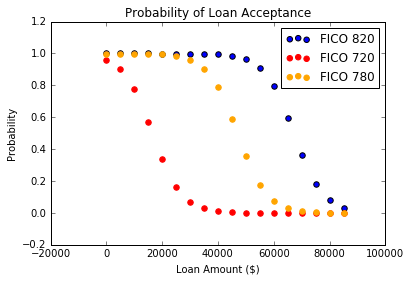

In [53]:
for amt in range(0,90000,5000):
    b = pz(820,amt,coeff)
    c = pz(720,amt,coeff)
    d = pz(780,amt,coeff)
    plt.scatter(amt,b,s=30)
    plt.scatter(amt,c,s=30, color='red')
    plt.scatter(amt,d,s=30, color='orange')
    plt.title("Probability of Loan Acceptance")
    plt.xlabel("Loan Amount ($)")
    plt.ylabel("Probability")
    plt.xlim=(0,10000)
    plt.ylim=(0,1)
    plt.legend(['FICO 820','FICO 720','FICO 780'])

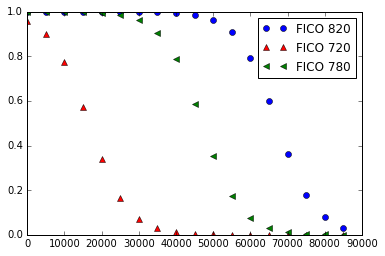

In [99]:
# Can do a similar thing with plt.plot and different symbols. Easy to get the axis right down to 0. 

leg_labs = ['FICO 820','FICO 720','FICO 780']
for amt in range(0,90000,5000):
    b = pz(820,amt,coeff)
    c = pz(720,amt,coeff)
    d = pz(780,amt,coeff)
    plt.plot(amt,b,'bo')
    plt.plot(amt,c,'r^')
    plt.plot(amt,d,'g<')
    plt.legend(leg_labs)

#### Extra Challenge
How would you create a plot that showed the probability of getting a loan as a function of BOTH FICO score and loan amount varying - what tools woudl you need?